# Movie Poster Genre
Lab Assignment Three: Exploring Image Data

**_Jake Oien, Seung Ki Lee, Jenn Le_**

## Business Understanding

Dataset Source: https://www.kaggle.com/neha1703/movie-genre-from-its-poster/data

### Purpose and Application

This dataset could be useful in identifying classification of the movie's genre from information gathered from the poster. Given that the dataset contains the ratings, year of release (within movie name), and the poster, we can utilize the categorized data to further analyze the relationships and trends in posters in regards to other factors. For instance, with proper increment in data we can track the change in trend of the posters as time changes, or find relationship between the rating of the movie in certain genre and the match rate of the poster to training dataset.

### Data Description

The dataset of over 40,000 movies contains the name of the movie, url to imdb website post of the movie, its rating, its ID on IMDB website, genres seperated by '|' character and its poster url from IMBD website. This fairly basic dataset contains list of movies from 1950s to 2010s, and while its not explicitly mentioned, from various cultures including italy, France, and India.

This data was collected directly from imdb website in June of 2017 and uploaded to https://www.kaggle.com/neha1703/movie-genre-from-its-poster/data

### End Goal

Our primary goal in analysis of this dataset would be to accurately classify the genre of an unknown movie from the information gathered from the movie's poster. Given that most of the movies are classfied with up to three genres the goal would be to correctly classify at least one of them.

### Measure of Success

There are over 25 major genres in imdb classification, and each of the movies can be classified under three genres at most. If our algorithm learns as expected we can expect success rate amounting to something better than out right guessing. So our initial goal is to get the classification above 4% for single genre movies and 12% for multi-genre ones with hopes that we can bring up the success rate up.

Hopefully with improvement, we will strive to bring up the level of a "guessing foreinger," a person who has no experience in films from certain culture. Because movie posters are something that relates highly to the culture in which one lives in, when a movie is exported to different cultures the movie posters are remastered and often completely remade.

For instance, poster on an Italian movie, "The War Zone" which rotates around the theme of human evil through rape and incest, has won the Berlin Pictures award and British Film award in 1999 and was exported to varios nations.

German Poster
http://postfiles4.naver.net/20150902_163/studio6982_1441122415809gtAkb_JPEG/150901_TheWarZone-6_Germany.jpg?type=w2

UK Poster
http://postfiles11.naver.net/20150902_10/studio6982_1441122416089gOgHU_JPEG/150901_TheWarZone-5_UK.jpg?type=w2

The German Poster depicts the camera-quality photo of victim as the subject of the misery in plot with her glaring at something despite the tear rolling down her cheek, giving the movie a scent of documentary about a life of a woman. The UK poster on the other hand displays almost picture-like camera work on the violence and evil with the CG symbolism of broken glasses in between the man and the woman, giving the movie a vibe of horror film. Thus it is only natural that people of different cultures having completely different view of the movie. Likewise, the prediction of the genre made by a person from different culture would and does have a lower success rate than a person more acustomed to the culture. For the purpose of this lab, we estimates 50% as this threshold which should be at least three to ten times more accurate than random selection.

## Data Preparation

### Data cleaning

Some of the dataset has entries without a poster url, so we trim those from the dataset.

In [1]:
import pandas as pd
import numpy as np

initial_dataset_filename = "MovieGenre_short.csv"
data = pd.read_csv("./{}".format(initial_dataset_filename), encoding='latin-1')
# clean the data
data = data[data.Poster.notnull()]
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 17
Data columns (total 6 columns):
imdbId        18 non-null int64
Imdb Link     18 non-null object
Title         18 non-null object
IMDB Score    18 non-null float64
Genre         18 non-null object
Poster        18 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 1008.0+ bytes


,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


We don't need the link to the movie or its score, so let's start by getting rid of those. 

In [ ]:
for col in ["Imdb Link", "IMDB Score"]: 
    if col in data:
        del data[col]
        
data.head()

Now we need to consider what we should do with the Genre. The movies have a multivalued field for their genre, which doesn't seem like it would be okay for classification. Ideally, we would like a single genre, but we have decided to duplicate the rows for each genre that makes it up, because the movie does technically belong to all 3 genres. In other systems, this is called exploding the list.

This operation was adapted from the Stack Overflow answer found [here](https://stackoverflow.com/a/12681217).

In [ ]:
# if type(data.Genredata.Genre = data.Genre.str.split("|")
# rows = []
# _ = data.apply(lambda row: [rows.append([row['imdbId'], row['Title'], genre, row["Poster"]]) 
#                          for genre in row.Genre.split("|")], axis=1)

# data_exploded = pd.DataFrame(data=rows, columns=data.columns)

# data_exploded.info()
# data_exploded.head(10)

### Read in Picture Data as Numpy Arrays & Linearize

Moreover, with over 40,000 movies in the dataset there are some expired or faulty urls leading to HTTPError of 404, so we had to use try except to load good images. To cut down on loading times, we download the images beforehand and store them in a folder. 

In [2]:
#set up for showing picture -> all pictures are of same size 268x128
import os
img_folder_name = initial_dataset_filename + "_images"
if not os.path.exists(img_folder_name):
    os.makedirs(img_folder_name)

saved_images_names = [filename for filename in os.listdir(img_folder_name) if filename.endswith(".bmp")]

In [3]:
%%time
import urllib
from PIL import Image
import io
import matplotlib.pyplot as plt
import os

%matplotlib inline

X= []

for index, row in data.iterrows():
    filename = "{}.bmp".format(row["imdbId"])
    filepath = "{}/{}".format(img_folder_name, filename)
    if filename not in saved_images_names:  
        filename_to_write = filepath
        
        # read in the image from the url, and skip poster with 404 error
        try:
            loadimg = urllib.request.urlopen(row["Poster"])
        except urllib.error.HTTPError as err: 
            if err.code == 404:
                continue
            else:
                raise
        print(filename_to_write)
        image_file = io.BytesIO(loadimg.read())
        
        # for converting files to gray  
        # -> http://pillow.readthedocs.io/en/3.4.x/reference/Image.html
        with Image.open(image_file).convert("L") as img:
            img_arr = np.array(img).flatten()
            img_arr = img_arr.reshape(img_arr.shape[0], 1)
            
            save_image = Image.fromarray(img_arr)
            save_image.save(filename_to_write)
            saved_images_names.append(filename) # to avoid downloading future copies
            
            X.append(img_arr)
            
    else:  # don't keep downloading the files, save them locally
        with Image.open(filepath) as img:
            img_array = np.array(img).flatten()
            img_array = img_array.reshape(img_array.shape[0], 1)
            X.append(img_array)

    
X = np.array(X)  # Image data
Y = np.array(data.Genre)  # Classifiers
#known pixels
h, w = 268, 182


CPU times: user 165 ms, sys: 55.7 ms, total: 221 ms
Wall time: 320 ms


In [ ]:
X.shape

### Visualize Image Samples

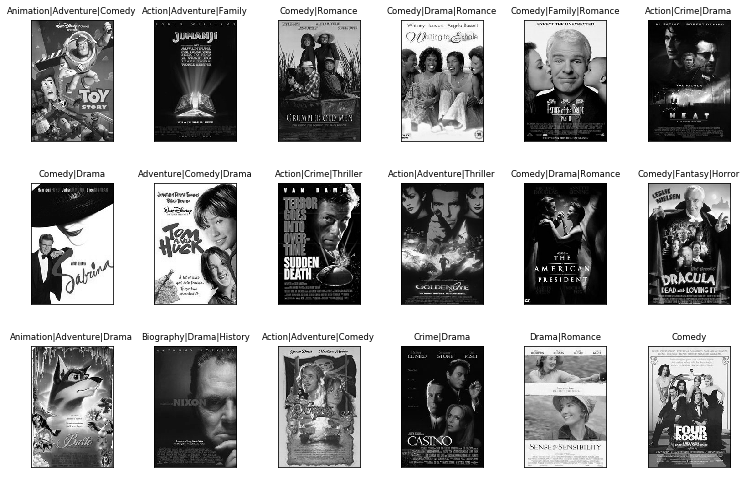

In [4]:
# a helper plotting function -> from class note
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape(h,w), cmap=plt.cm.gray) #no need for reshaping as all are of same size
        plt.title(titles[i], size=8.5)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X, Y, h, w) # defaults to showing a 3 by 6 subset of the faces
plt.show()


# Data Reduction

### Dimensionality Reduction

To make our data easier to work with, we'll reduce the number of dimensions that are being represented. First, we'll use PCA for linear dimensionality reduction and see how well that goes.

### Feature extraction

We will use the Daisy method, as discussed in class. Much of the code will be adapted from workbook 04.

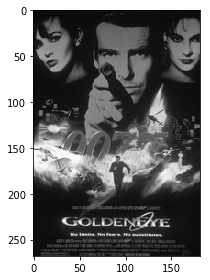

In [5]:
from skimage.feature import daisy
from skimage.io import imshow

idx_to_reconstruct = int(np.random.rand(1)*len(X))
img  = X[idx_to_reconstruct].reshape((h,w))
imshow(img)

(268, 182)


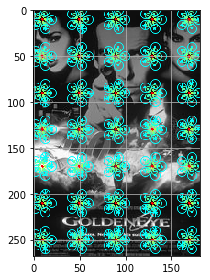

In [6]:
print (img.shape)
daisy_img = X[idx_to_reconstruct]
features, img_desc = daisy(img,step=40, radius=10, rings=3, histograms=5, orientations=8, visualize=True)
imshow(img_desc)
plt.grid()

We want more overlap if we can help it, so let's adjust the parameters. 

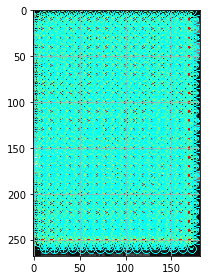

In [12]:
step=10
radius=10
rings=3
histograms=5
orientations=8

features, img_desc = daisy(img,step=step, radius=radius, rings=rings, histograms=histograms, orientations=orientations, visualize=True)
imshow(img_desc)
plt.grid()

Ah, much better. Now we apply daisy to get the features. 

In [13]:
# create a function to take in the row of the matric and return a new feature
def apply_daisy(row,shape):
    features = daisy(row.reshape(shape),step=step, radius=radius, rings=rings, histograms=histograms, orientations=orientations, visualize=False)
    return features.reshape((-1))

# apply to entire data, row by row,
daisy_features = np.apply_along_axis(apply_daisy, 1, X, (h,w))
print(daisy_features.shape)

(18, 54400, 1)


We need to get rid of the outer dimension for pairwise distances to work. 

In [14]:
print("Dimensions before squeese: {}".format(daisy_features.shape))
daisy_features = np.squeeze(daisy_features, axis=2)
print("Dimensions after squeeze: {}".format(daisy_features.shape))

Dimensions before squeese: (18, 54400, 1)
Dimensions after squeeze: (18, 54400)


In [15]:
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(daisy_features)
print(dist_matrix.shape)

CPU times: user 6.67 ms, sys: 1.25 ms, total: 7.92 ms
Wall time: 4.98 ms
(18, 18)


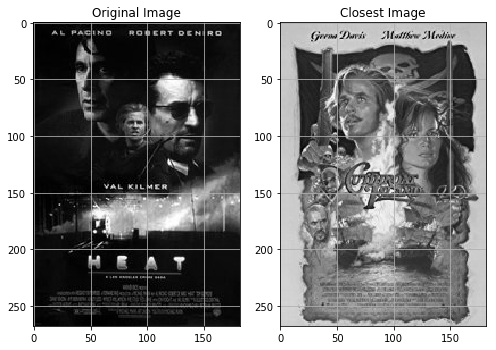

In [16]:
import copy
# find closest image to current image
idx1 = 5
distances = copy.deepcopy(dist_matrix[idx1,:])
distances[idx1] = np.infty # dont pick the same image!
idx2 = np.argmin(distances)

plt.figure(figsize=(7,10))
plt.subplot(1,2,1)
imshow(X[idx1].reshape((h,w)))
plt.title("Original Image")
plt.grid()

plt.subplot(1,2,2)
imshow(X[idx2].reshape((h,w)))
plt.title("Closest Image")
plt.grid()